In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
#Load Dataset crypto-markets Dataset
#Source from https://www.kaggle.com/jessevent/all-crypto-currencies 

In [2]:
PATH = 'drive/My Drive/Dicoding BPML/Submission 2/'
crypto_prices = pd.read_csv(PATH+'crypto-markets.csv')

#Use BITS prices only to predict BITS open prices, and get rid of the other cryptocurrencies
BITS_price = crypto_prices[crypto_prices.symbol == 'BITS']

In [3]:
BITS_price.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
487523,bitcoinus,BITS,Bitcoinus,2018-10-17,1130,0.006703,0.009399,0.006592,0.008622,140708.0,0.0,0.7232,0.0
487524,bitcoinus,BITS,Bitcoinus,2018-10-18,1130,0.008760,0.009482,0.007911,0.008070,157678.0,357468.0,0.1012,0.0
487525,bitcoinus,BITS,Bitcoinus,2018-10-19,1130,0.008059,0.009832,0.007966,0.008440,29579.0,373825.0,0.2540,0.0
487526,bitcoinus,BITS,Bitcoinus,2018-10-20,1130,0.008756,0.008778,0.007025,0.008140,34603.0,360544.0,0.6361,0.0
487527,bitcoinus,BITS,Bitcoinus,2018-10-21,1130,0.008143,0.008144,0.006519,0.007309,93842.0,323743.0,0.4862,0.0


In [ ]:
BITS_price.tail()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
689734,bitstar,BITS,Bitstar,2018-11-25,1460,0.004254,0.004868,0.004044,0.004325,47.0,85882.0,0.3410,0.0
689735,bitstar,BITS,Bitstar,2018-11-26,1460,0.004324,0.004444,0.003902,0.004141,0.0,82231.0,0.4410,0.0
689736,bitstar,BITS,Bitstar,2018-11-27,1460,0.004141,0.004141,0.004141,0.004141,0.0,82243.0,0.0000,0.0
689737,bitstar,BITS,Bitstar,2018-11-28,1460,0.004141,0.004564,0.004141,0.004421,1.0,87826.0,0.6619,0.0
689738,bitstar,BITS,Bitstar,2018-11-29,1460,0.004439,0.004537,0.004212,0.004321,6.0,85854.0,0.3354,0.0


# Data Preprocessing

In [4]:
#Check for null values and the statistical measurement
print(BITS_price.isna().sum())
print(BITS_price.describe())

slug           0
symbol         0
name           0
date           0
ranknow        0
open           0
high           0
low            0
close          0
volume         0
market         0
close_ratio    0
spread         0
dtype: int64
           ranknow         open  ...  close_ratio       spread
count  3189.000000  3189.000000  ...  3189.000000  3189.000000
mean   1391.693948     0.143435  ...     0.462185     0.027774
std      74.650640     0.338785  ...     0.341334     0.093581
min    1130.000000     0.000324  ...     0.000000     0.000000
25%    1323.000000     0.005021  ...     0.136800     0.000000
50%    1460.000000     0.022573  ...     0.423600     0.000000
75%    1460.000000     0.067325  ...     0.787100     0.010000
max    1460.000000     2.380000  ...     1.000000     2.360000

[8 rows x 9 columns]


In [5]:
#Get rid of features that has no relevancy and undescribed features
BITS_price = BITS_price.drop(['slug', 'symbol', 'name', 'ranknow', 'market'], axis=1)

#Normalize the volume features
BITS_price.volume = (BITS_price.volume-BITS_price.volume.min()
                     )/(BITS_price.volume.max()-BITS_price.volume.min())

In [6]:
#Sorting by dates
dates = pd.to_datetime(BITS_price.date)
BITS_price = BITS_price.drop('date', axis=1)
BITS_price['date'] = dates

BITS_price = BITS_price
BITS_price_sorted = BITS_price.sort_values(by='date')
BITS_price_sorted = BITS_price_sorted.reset_index()

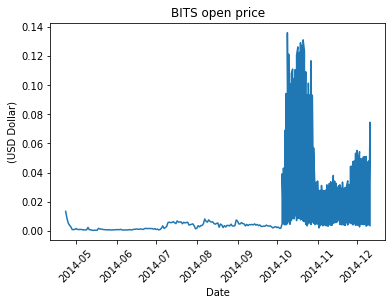

In [ ]:
%matplotlib inline

#Plot BITS open price
dates = BITS_price_sorted.date
target_open_price = BITS_price_sorted.open.values

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(dates[:300], target_open_price[:300])
ax.set(xlabel="Date",
       ylabel="(USD Dollar)",
       title="BITS open price")
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

#Data Slicing and Splitting

In [7]:
#Slice the timeframe data using windowed_dataset function

def windowed_dataset(series, windows_length):
    NO_timesample, NO_feat = series.shape
    
    X = np.zeros([NO_timesample, windows_length, NO_feat])
    y = np.zeros(NO_timesample)
    
    counter = 0
    for i in range (NO_timesample) :
        try:
            X[i] = series[i:i+windows_length]
            y[i] = series[i+windows_length,0]
            counter += 1
        except IndexError:
            break
    return X[:counter], y[:counter]

data = BITS_price_sorted.drop(['date','index'], axis=1).values
X,y = windowed_dataset(data, 7)

In [8]:
#Calculate the maximum values of the open price
max_val = y.max() - y.min()
max_mae = (4/100)*max_val

In [9]:
#Split timeframe data for train and val data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 300)

In [10]:
X_train.shape

(2545, 7, 7)

# Build Tensorflow Model

In [ ]:
#Construct the Tensorflow Model
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae')<max_mae):
            print('\nMaximum nilai (skala) data : {}'.format(max_val))
            print("\nTelah tercapai mae < 4% skala data !")
            self.model.stop_training = True
callbacks = myCallback()

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(7, recurrent_dropout=0.2, return_sequences=True),
  tf.keras.layers.LSTM(7,recurrent_dropout=0.2),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

callbacks = myCallback()

optimizer = tf.keras.optimizers.Adam(lr=1e-04)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(x=X_train, y=y_train, epochs=500, batch_size=32, 
                    validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/500
80/80 [==============================] - 1s 17ms/step - loss: 0.0600 - mae: 0.1409 - val_loss: 0.0454 - val_mae: 0.1280
Epoch 2/500
80/80 [==============================] - 1s 11ms/step - loss: 0.0558 - mae: 0.1499 - val_loss: 0.0423 - val_mae: 0.1415
Epoch 3/500
80/80 [==============================] - 1s 11ms/step - loss: 0.0525 - mae: 0.1623 - val_loss: 0.0398 - val_mae: 0.1521
Epoch 4/500
80/80 [==============================] - 1s 11ms/step - loss: 0.0490 - mae: 0.1678 - val_loss: 0.0371 - val_mae: 0.1539
Epoch 5/500
80/80 [==============================] - 1s 12ms/step - loss: 0.0450 - mae: 0.1659 - val_loss: 0.0343 - val_mae: 0.1483
Epoch 6/500
80/80 [==============================] - 1s 12ms/step - loss: 0.0412 - mae: 0.1579 - val_loss: 0.0324 - val_mae: 0.1419
Epoch 7/500
80/80 [==============================] - 1s 13ms/step - loss: 0.0384 - mae: 0.1471 - val_loss: 0.0317 - val_mae: 0.1387
Epoch 8/500
80/80 [==============================] - 1s 12ms/step - loss: 0.

In [ ]:
mae_train = history.history['mae']
mae_val = history.history['val_mae']
train_loss = history.history['loss']

epoch = np.arange(152)

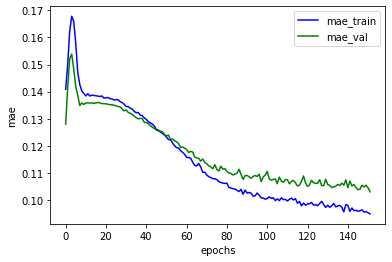

In [ ]:
plt.plot(epoch, mae_train, 'b')
plt.plot(epoch, mae_val, 'g')
plt.xlabel('epochs')
plt.ylabel('mae')
plt.legend(['mae_train', 'mae_val'])

Text(0, 0.5, 'loss')

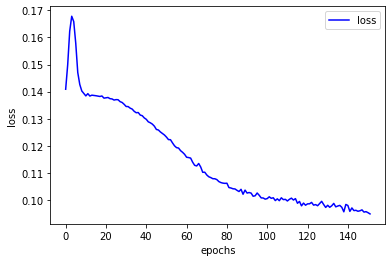

In [ ]:
plt.plot(epoch, mae_train, 'b')
plt.legend(['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')